# Tracking with Continuous Integration

The previous attempt at tracking calculated after processing a 1ms block of data. This notebook keeps a running integration so that the replica code can be moved after every sample.



In [39]:
import numpy as np
import matplotlib.pyplot as plt

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

In [109]:
# Need these to pass to importFile module
fs = 4.092*10**6
SampleLength = 0.001

BytesToSkip = 0

data = IQData()
data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)

Opening a file.
File handle is: 67.
Total Samples to read: 4092
Total Bytes read: 2046.
Which equals 4092 IQ pairs.
Sample Length: 0.001000 seconds.
File is now closed.


In [110]:
# Tracking Loop maybe
segLen = 1023 * 4 #1ms
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]
Satellite = 13

#set the buffer size
BUFFER_SIZE = 1000

spc = 4 #Samples per Chip
spd = 1023 * spc #samples per code
startPhase = 1471  #in samples
startFreq = 12 #in Hz
carrFreq = startFreq

# Create Code Generator object for chosen Satellite and make a code
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero
Code = CodeGen.getCode(1023 * 2, samplesPerChip = spc)

#Starting code and buffer pointers
codeI =  int(startPhase  % spd)
bufI = 0


buf_ie = np.zeros(BUFFER_SIZE)
buf_ip = np.zeros(BUFFER_SIZE)
buf_il = np.zeros(BUFFER_SIZE)

buf_qe = np.zeros(BUFFER_SIZE)
buf_qp = np.zeros(BUFFER_SIZE)
buf_ql = np.zeros(BUFFER_SIZE)


#Init Recording arrays
ie = np.zeros(len(data.IData))
ip = np.zeros(len(data.IData))
il = np.zeros(len(data.IData))

qe = np.zeros(len(data.IData))
qp = np.zeros(len(data.IData))
ql = np.zeros(len(data.IData))

d = np.zeros(len(data.IData))
c = np.zeros(len(data.IData))

a = []
#Init vars for Filtering
#NOTE: Find the taus from the MATLAB code and test it using them
tau1c = .000117#1.04052829032035935 #1000000000.0#
tau2c = .0296#.009001805454050047 #1414.0#

tau1d = .0698
tau2d = .3700

lastNCOc = 0.0
lastcarrdiscrm = 0.0

lastNCOd = 0.0
lastcodediscrm = 0.0


#a=[]

#Mix samples to baseband
IDataShifted = (data.IData)* np.cos(2 * np.pi* carrFreq * data.t) 
QDataShifted = data.QData *  np.sin(2 * np.pi* carrFreq * data.t)
i = 0
add = 1
for u in range(len(IDataShifted)):
   
    #Mix code with data to get correlation 
    ImixP = Code[codeI] * IDataShifted[u]
    ImixE = Code[codeI-2] * IDataShifted[u]
    ImixL = Code[codeI+2] * IDataShifted[u]

    QmixP = Code[codeI] * QDataShifted[u]
    QmixE = Code[codeI - 2] * QDataShifted[u]
    QmixL = Code[codeI + 2] * QDataShifted[u]
    
    #Write to buffers
    buf_ie[bufI] = ImixE
    buf_ip[bufI] = ImixP
    buf_il[bufI] = ImixL
    
    buf_qe[bufI] = QmixE 
    buf_qp[bufI] = QmixP
    buf_ql[bufI] = QmixL
    

    #Integrate buffers
    intIE = np.sum(buf_ie)
    intIP = np.sum(buf_ip)
    intIL = np.sum(buf_il)

    intQE = np.sum(buf_qe)
    intQP = np.sum(buf_qp)
    intQL = np.sum(buf_ql)

    #Find discrminators
    discriminator = ((intIE ** 2 + intQE ** 2) - (intIL ** 2 + intQL ** 2)) / ((intIE ** 2 + intQE ** 2) + (intIL ** 2 + intQL ** 2))
    carrierdiscrm = (np.arctan(intQP/intIP)) /(2.0 * np.pi)
    
    #Advance pointers
    bufI = (bufI + 1 ) % BUFFER_SIZE
    
    #Messing with feedback
    if (i > 2700):
        if discriminator > 0.125 and discriminator < 0.75:
            add = 0
        elif discriminator < -.125 and discriminator > .75:
            add = 2
        elif discriminator >= .75:
            add = -1
        elif discriminator <= -.75:
            add = 3
        else:
            add = 1
        add = int(np.round(discriminator  * 2) ) + 1
    a.append(add)
    #a.append(add)
    codeI = (codeI + add) % 1023
    
    #Record values      
    ie[u] = intIE
    ip[u] = intIP
    il[u] = intIL
    
    qe[u] = intQE
    qp[u] = intQP
    ql[u] = intQL

    d[u] = discriminator
    c[u] = carrierdiscrm
    
    
    
    #Carrier feedback
    
    carrNCO = lastNCOc + (tau2c / tau1c) * (carrierdiscrm - lastcarrdiscrm) + carrierdiscrm * (.001/tau1c)
    lastNCOc = carrNCO
    lastcarrdiscrm = carrierdiscrm
    
    carrFreq = startFreq + carrNCO
    
    #Code feedback
    codeNCO = lastNCOd + (tau2d / tau1d) * (discriminator - lastcodediscrm) + discriminator * (.001/tau1d)
    lastNCOd = codeNCO
    lastcodediscrm = discriminator
    
    i += 1
    

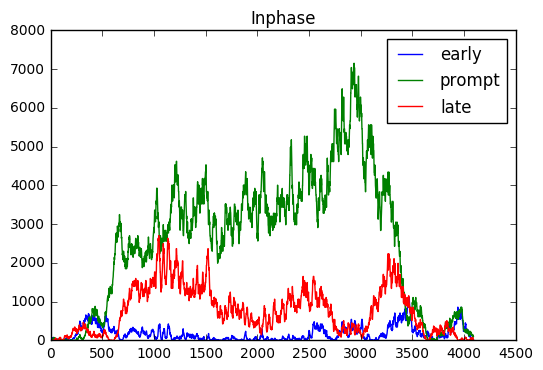

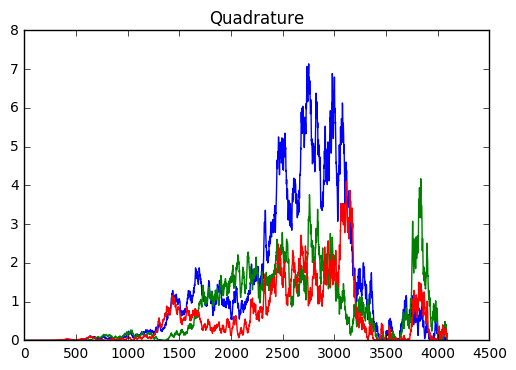

In [111]:
plt.plot(ie ** 2, label = 'early')
plt.plot(ip ** 2, label = 'prompt')
plt.plot(il ** 2, label = 'late')
plt.legend()
plt.title('Inphase')
plt.show()

plt.plot(qe ** 2, label = 'early')
plt.plot(qp ** 2, label = 'prompt')
plt.plot(ql ** 2, label = 'late')
plt.title('Quadrature')

plt.show()

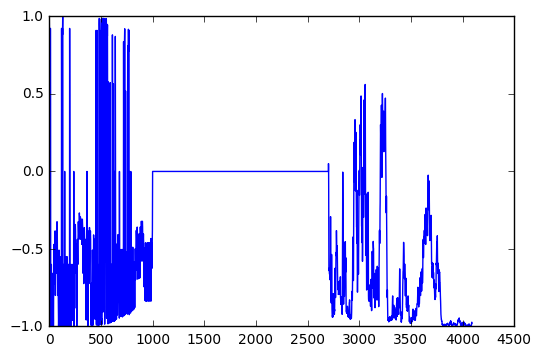

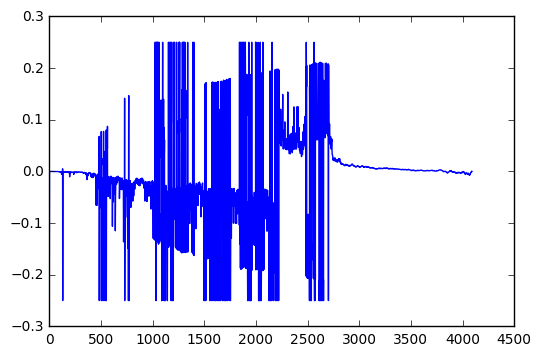

In [92]:
plt.plot(d)
plt.show()
plt.plot(c)
plt.show()

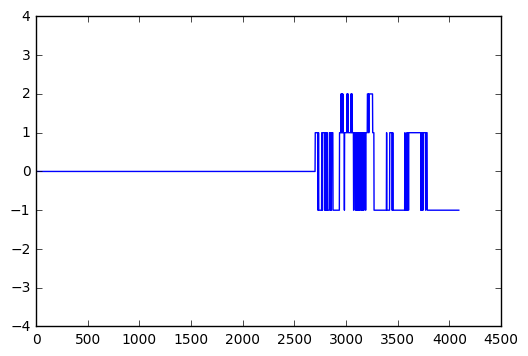

In [93]:
plt.plot(a)
plt.ylim([-4, 4])
plt.show()